In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import gc
import warnings
import os
import time

from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold

#warnings.simplefilter(action='ignore', category=FutureWarning)

print(os.listdir("../Projet+Mise+en+prod+-+home-credit-default-risk"))

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))



['application_test.csv', '.DS_Store', 'HomeCredit_columns_description.csv', 'POS_CASH_balance.csv', 'credit_card_balance.csv', 'installments_payments.csv', 'application_train.csv', 'bureau.csv', 'previous_application.csv', 'bureau_balance.csv', 'sample_submission.csv']


In [2]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns.sort_values('% of Total Values', 
                                                                          ascending=False).round(1)
          #  mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
       # '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [3]:
# read the df 
main_model_df = pd.read_csv("../my_csv_files/df_for_modelling.csv")

In [4]:
# Missing values statistics
missing_values = missing_values_table(main_model_df)
missing_values.to_csv("../my_csv_files/missing_values.csv")
missing_values.head(20)

Your selected dataframe has 799 columns.
There are 799 columns that have missing values.


,Missing Values,% of Total Values
REFUSED_RATE_DOWN_PAYMENT_MIN,303648,85.2
REFUSED_RATE_DOWN_PAYMENT_MEAN,303648,85.2
REFUSED_AMT_DOWN_PAYMENT_MEAN,303648,85.2
REFUSED_AMT_DOWN_PAYMENT_MAX,303648,85.2
REFUSED_AMT_DOWN_PAYMENT_MIN,303648,85.2
REFUSED_RATE_DOWN_PAYMENT_MAX,303648,85.2
REFUSED_APP_CREDIT_PERC_VAR,298034,83.7
CC_AMT_PAYMENT_CURRENT_VAR,284649,79.9
CC_AMT_DRAWINGS_OTHER_CURRENT_VAR,284559,79.9
CC_CNT_DRAWINGS_OTHER_CURRENT_VAR,284559,79.9


In [5]:
missing_values.tail(400)

,Missing Values,% of Total Values
PREV_AMT_GOODS_PRICE_MIN,18462,5.2
PREV_AMT_ANNUITY_MAX,17878,5.0
PREV_AMT_ANNUITY_MEAN,17878,5.0
PREV_AMT_ANNUITY_MIN,17878,5.0
PREV_CNT_PAYMENT_MEAN,17876,5.0
...,...,...
ORGANIZATION_TYPE_Electricity,0,0.0
ORGANIZATION_TYPE_Culture,0,0.0
ORGANIZATION_TYPE_Construction,0,0.0
ORGANIZATION_TYPE_Cleaning,0,0.0


In [6]:
data_for_feat_selec1 = missing_values.tail(400)

In [79]:
type(main_model_df['SK_ID_CURR'][0])

numpy.int64

In [80]:
main_model_df

,Unnamed: 0,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,0,100002,1.0,0,0,0,0,202500.0,406597.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,100004,0.0,0,1,0,0,67500.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,100006,0.0,1,0,0,0,135000.0,312682.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,4,4,100007,0.0,0,0,0,0,121500.0,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356246,356250,48739,456221,NaN,1,0,0,0,121500.0,412560.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356247,356251,48740,456222,NaN,1,0,1,2,157500.0,622413.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356248,356252,48741,456223,NaN,1,1,0,1,202500.0,315000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356249,356253,48742,456224,NaN,0,0,1,0,225000.0,450000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Modelling Start

## Create my own cost function and divide into test / train

In [7]:
import re

# Divide in training/validation and test data
main_model_df = main_model_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

train_df = main_model_df[main_model_df['TARGET'].notnull()]
test_df = main_model_df[main_model_df['TARGET'].isnull()]


# Cross validation model
#if stratified:
#    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
#else:
#    folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    
# Create arrays and dataframes to store results
feats = [f for f in train_df.columns if f not in ['TARGET', 'Unnamed: 0', 'Unnamed0',
                                                  'SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

# Sklearn stuff
#from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

# Load and split dataset
#x, y = load_breast_cancer(return_X_y=True)

x_train, x_test, y_train, y_test = train_test_split(train_df[feats], train_df['TARGET'], 
                                                    test_size=0.3, random_state = 22)



In [8]:
del test_df
gc.collect()

0

## Hyperparameter Search: from hyperopt

In [9]:
from sklearn.metrics import confusion_matrix
import numpy as np

def my_comp_score(y_true, y_pred):

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    tn_weight = 1
    fp_weight = 0
    fn_weight = -10
    tp_weight = 0

    # gain function for company, true positives and false positives don't matter that much to us
    # we want to penalise the false negatives, and we want to say yes to true negatives
    gain = tp*(tp_weight) + tn*(tn_weight) + fp*(fp_weight) + fn*(fn_weight)
    
    # best represents scenario where there are no false negatives or false postives
    # so all false positives would be correctly shown as negative
    # and all false negatives would be correctly show as positive
    best = (tn + fp) * tn_weight + (tp + fn) * tp_weight
    
    # baseline is a naive model that predicts non default(negative) for everyone
    # but all true positives and false negatives would be incorrectly shown as negative
    baseline = (tn + fp) * tn_weight + (tp + fn) * fn_weight
    
    score = (gain - baseline) / (best - baseline)
    
    return score



def my_comp_score_probs(y_true, y_pred):
    
    # for now y_pred is the probability that the value is 1
    y_use = [1 if i >= 0.4 else 0 for i in y_pred]
    
    y_use = pd.Series(y_use)

    tn, fp, fn, tp = confusion_matrix(y_true, y_use).ravel()
    
    tn_weight = 1
    fp_weight = 0
    fn_weight = -10
    tp_weight = 0

    # gain function for company, true positives and false positives don't matter that much to us
    # we want to penalise the false negatives, and we want to say yes to true negatives
    gain = tp*(tp_weight) + tn*(tn_weight) + fp*(fp_weight) + fn*(fn_weight)
    
    # best represents scenario where there are no false negatives or false postives
    # so all false positives would be correctly shown as negative
    # and all false negatives would be correctly show as positive
    best = (tn + fp) * tn_weight + (tp + fn) * tp_weight
    
    # baseline is a naive model that predicts non default(negative) for everyone
    # but all true positives and false negatives would be incorrectly shown as negative
    baseline = (tn + fp) * tn_weight + (tp + fn) * fn_weight
    
    score = ((gain - baseline) / (best - baseline))

    return score

In [10]:
from sklearn.metrics import fbeta_score, make_scorer
make_scorer(my_comp_score)

make_scorer(my_comp_score)

In [11]:
from hyperopt import fmin, tpe, hp, anneal, Trials

# HyperOpt: Optimizer
from hyperopt import tpe

kf = KFold(n_splits = 5)

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def gb_mse_cv(params, random_state = 22, cv = kf, X = x_train, y= y_train):
    # the function gets a set of variable parameters in "param"
    params = {'learning_rate': params['learning_rate'],
              'num_leaves': int(params['num_leaves']),
              'subsample' : params['subsample'],
              'max_depth': int(params['max_depth']),
              'reg_alpha' : params['reg_alpha'],
              'reg_lambda' : params['reg_lambda'],
              'min_data_in_leaf': int(params['min_data_in_leaf']),
              'min_split_gain' :  params['min_split_gain']
              }
    
    # we use this params to create a new LGBM Regressor
    model = LGBMClassifier(random_state = random_state, **params)
    
    # and then conduct the cross validation with the same folds as before
    score = -cross_val_score(model, X, y, cv=cv, scoring= make_scorer(my_comp_score_probs, needs_proba= True), 
                             n_jobs=-1).mean()

    return score


In [13]:
%%time

n_iter = 50

# possible values of parameters
space = {'learning_rate': hp.loguniform('learning_rate', -5, 0),
         'num_leaves' : hp.quniform('num_leaves', 2, 40, 1),
         'subsample' : hp.loguniform('subsample', -4, 0),
         'max_depth' : hp.quniform('max_depth', 2, 14, 1),
         'reg_alpha' : hp.loguniform('reg_alpha', -4, 0),
         'reg_lambda' : hp.loguniform('reg_lambda', -4, 0),
         'min_data_in_leaf': hp.quniform('min_data_in_leaf', 2, 40, 1),
         'min_split_gain' : hp.loguniform('min_split_gain', -4, 0)
        }

# trials will contain logging information
trials = Trials()

best=fmin(fn=gb_mse_cv, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=n_iter, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.RandomState(58) # fixing random state for the reproducibility
         )

# computing the score on the test set
model = LGBMClassifier(random_state = 54,
                       learning_rate = best['learning_rate'],
                       num_leaves = int(best['num_leaves']), 
                       subsample = best['subsample'],
                       max_depth = int(best['max_depth']),
                       reg_alpha = best['reg_alpha'],
                       reg_lambda = best['reg_lambda'],
                       min_data_in_leaf = int(best['min_data_in_leaf']),
                       min_split_gain = best['min_split_gain']
                       )

model.fit(x_train, y_train)

print("Best  {:.3f} params {}".format( gb_mse_cv(best), best))


100%|██████████| 50/50 [1:09:52<00:00, 83.85s/trial, best loss: -0.12047616544190595]
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
Best  -0.120 params {'learning_rate': 0.6746831272594017, 'max_depth': 6.0, 'min_data_in_leaf': 24.0, 'min_split_gain': 0.022723192110707714, 'num_leaves': 39.0, 'reg_alpha': 0.03395861057242615, 'reg_lambda': 0.7479143518896737, 'subsample': 0.08852311849966028}
CPU times: user 1min 28s, sys: 44.6 s, total: 2min 13s
Wall time: 1h 11min 42s


In [14]:
print("Best  {:.3f} params {}".format( gb_mse_cv(best), best))

Best  -0.120 params {'learning_rate': 0.6746831272594017, 'max_depth': 6.0, 'min_data_in_leaf': 24.0, 'min_split_gain': 0.022723192110707714, 'num_leaves': 39.0, 'reg_alpha': 0.03395861057242615, 'reg_lambda': 0.7479143518896737, 'subsample': 0.08852311849966028}


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

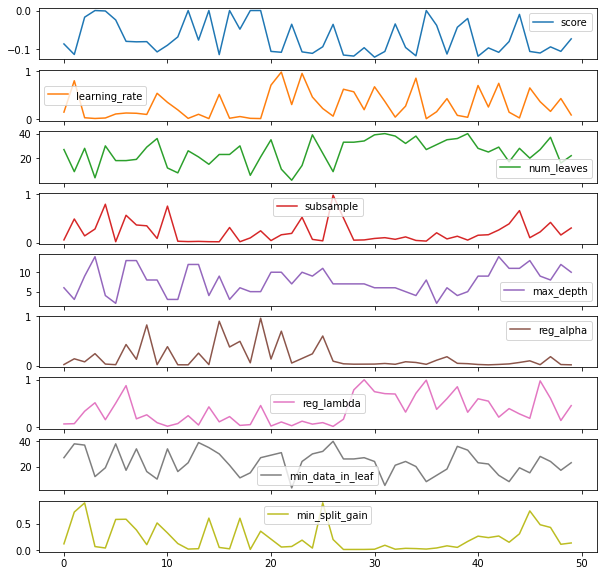

In [15]:
#tpe_test_score=mean_squared_error(x_test, model.predict(y_test))

tpe_results = np.array([[x['result']['loss'],
                         x['misc']['vals']['learning_rate'][0],
                         x['misc']['vals']['num_leaves'][0],
                         x['misc']['vals']['subsample'][0],
                         x['misc']['vals']['max_depth'][0],
                         x['misc']['vals']['reg_alpha'][0],
                         x['misc']['vals']['reg_lambda'][0],
                         x['misc']['vals']['min_data_in_leaf'][0],
                         x['misc']['vals']['min_split_gain'][0]] for x in trials.trials])

tpe_results_df = pd.DataFrame(tpe_results,
                           columns=['score', 'learning_rate', 'num_leaves',
                                    'subsample',
                                    'max_depth',
                                    'reg_alpha',
                                    'reg_lambda',
                                    'min_data_in_leaf',
                                    'min_split_gain'])
                                    
tpe_results_df.plot(subplots=True,figsize=(10, 10))

In [ ]:
model

In [31]:
import pickle
import joblib

#+ "/classification/models/"
#model, vectorizer_model = train_test_model(data["text"], data["category"])
joblib.dump(model, "../Models/hyperpar_search_lgbm_thresh03model.sav")
#joblib.dump(vectorizer_model, model_path+"vectorizer.sav")
print ("====done saving into pickle using Joblib!====")

pickle.dump(model, open("../Models/hyperpar_search_lgbm_thresh03model.pickle", 'wb'))
#pickle.dump(vectorizer_model, open(model_path+"vectorizer.pickle", "wb"))
print ("====done saving into pickle using Pickle!====")

====done saving into pickle using Joblib!====
====done saving into pickle using Pickle!====


In [ ]:
def loading_pickle(model_path):
    #vectorizer = pickle.load(open(model_path+"vectorizer.pickle",'rb'))
    model = pickle.load(open(model_path+"model.pickle",'rb'))
    return model
    #return vectorizer, model


def loading_joblibPickle(model_path):
    #vectorizer = joblib.load(model_path+"vectorizer.sav")
    model = joblib.load(model_path+"model.sav")
    return model 
    #return vectorizer, model

In [ ]:
loading_pickle(model_path)

## Launching the model

In [16]:
from sklearn.metrics import confusion_matrix
import numpy as np

def my_comp_score_lgbm(y_true, y_pred):
    
    # for now y_pred is the probability that the value is 1
    y_use = [1 if i >= 0.4 else 0 for i in y_pred]
    
    y_use = pd.Series(y_use)

    tn, fp, fn, tp = confusion_matrix(y_true, y_use).ravel()
    
    tn_weight = 1
    fp_weight = 0
    fn_weight = -10
    tp_weight = 0

    # gain function for company, true positives and false positives don't matter that much to us
    # we want to penalise the false negatives, and we want to say yes to true negatives
    gain = tp*(tp_weight) + tn*(tn_weight) + fp*(fp_weight) + fn*(fn_weight)
    
    # best represents scenario where there are no false negatives or false postives
    # so all false positives would be correctly shown as negative
    # and all false negatives would be correctly show as positive
    best = (tn + fp) * tn_weight + (tp + fn) * tp_weight
    
    # baseline is a naive model that predicts non default(negative) for everyone
    # but all true positives and false negatives would be incorrectly shown as negative
    baseline = (tn + fp) * tn_weight + (tp + fn) * fn_weight
    
    score = ((gain - baseline) / (best - baseline))

    return 'my score', score, True

In [17]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('../lgbm_importances02.png')

In [18]:
#main_model_df


In [19]:
import re

num_folds= 10
stratified= False
#debug= debug

# Divide in training/validation and test data
main_model_df = main_model_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

train_df = main_model_df[main_model_df['TARGET'].notnull()]
test_df = main_model_df[main_model_df['TARGET'].isnull()]
print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
del main_model_df
gc.collect()

# Cross validation model
if stratified:
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
else:
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    
# Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()

# Create arrays and dataframes to store results
feats = [f for f in train_df.columns if f not in ['TARGET', 'Unnamed: 0', 'Unnamed0',
                                                  'SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]


Starting LightGBM. Train shape: (307507, 799), test shape: (48744, 799)


In [20]:
#Best  -0.089 params {'learning_rate': 0.6558478063333454, 'max_depth': 5.0, 'min_data_in_leaf': 21.0, 
# 'n_estimators': 784.0, 'num_leaves': 33.0}

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
    train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
    valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
    
    train_x.to_csv("../my_csv_files/MY_train_x.csv")
    valid_x.to_csv("../my_csv_files/MY_valid_x.csv")
    valid_y.to_csv("../my_csv_files/MY_valid_y.csv")

    ##LightGBM parameters found by Bayesian optimization, Kaggle version
    #clf = LGBMClassifier(
    #    nthread=4,
    #    n_estimators=10000,
    #    learning_rate=0.02,
    #    num_leaves=34,
    #    colsample_bytree=0.9497036,
    #    subsample=0.8715623,
    #    max_depth=8,
    #    reg_alpha=0.041545473,
    #    reg_lambda=0.0735294,
    #    min_split_gain=0.0222415,
    #    min_child_weight=39.3259775,
    #    silent=-1,
    #    verbose=-1, )
    
    # Light GBM parameters found by my hyperparameter search
    clf = LGBMClassifier(
        nthread=4,
        n_estimators=10000,
        learning_rate = 0.6746831272594017,
        num_leaves = 39,
        max_depth = 6,
        reg_alpha = 0.03395861057242615,
        reg_lambda = 0.7479143518896737,
        min_data_in_leaf = 24,
        subsample = 0.08852311849966028,
        min_split_gain = 0.022723192110707714,
        silent=-1,
        verbose=-1, )
    
    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            verbose= 200, early_stopping_rounds= 200, eval_metric = my_comp_score_lgbm)

    oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
    
    valid_preds = clf.predict(valid_x, num_iteration = clf.best_iteration_)
    valid_preds_proba = clf.predict_proba(valid_x, num_iteration = clf.best_iteration_)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis = 0)
    #print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    #del clf, train_x, train_y, valid_x, valid_y
    #gc.collect()


Training until validation scores don't improve for 200 rounds
[200]	training's binary_logloss: 0.123671	training's my score: 0.596564	valid_1's binary_logloss: 0.294348	valid_1's my score: 0.125938
Early stopping, best iteration is:
[9]	training's binary_logloss: 0.235938	training's my score: 0.120332	valid_1's binary_logloss: 0.252213	valid_1's my score: 0.0966797
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
Training until validation scores don't improve for 200 rounds
[200]	training's binary_logloss: 0.124878	training's my score: 0.591514	valid_1's binary_logloss: 0.289987	valid_1's my score: 0.128082
Early stopping, best iteration is:
[11]	training's binary_logloss: 0.234107	training's my score: 0.128071	valid_1's binary_logloss: 0.248305	valid_1's my score: 0.0888396
[LightGBM] [Warning] n

In [21]:
clf.best_iteration_

7

In [32]:
import pickle
import joblib

joblib.dump(clf, "../Models/lgbm__trained_my_score03.sav")
pickle.dump(clf, open("../Models/lgbm_trained_my_score03.pickle", 'wb'))


In [8]:
# binary logloss version of LGBM

import pickle
import joblib

joblib.load("../Models/lgbm__trained_my_hypers_my_scorer1.sav")


LGBMClassifier(learning_rate=0.7, max_depth=7, min_data_in_leaf=35,
               min_split_gain=0.10084477620937958, n_estimators=10000,
               nthread=4, num_leaves=32, reg_lambda=0.8748371874180665,
               silent=-1, subsample=0.5685052618291946, verbose=-1)

In [22]:
feature_importance_df

,feature,importance,fold
0,CODE_GENDER,5,1
1,FLAG_OWN_CAR,0,1
2,FLAG_OWN_REALTY,0,1
3,CNT_CHILDREN,0,1
4,AMT_INCOME_TOTAL,0,1
...,...,...,...
790,CC_NAME_CONTRACT_STATUS_nan_MAX,0,10
791,CC_NAME_CONTRACT_STATUS_nan_MEAN,0,10
792,CC_NAME_CONTRACT_STATUS_nan_SUM,0,10
793,CC_NAME_CONTRACT_STATUS_nan_VAR,0,10


In [ ]:
joblib.load('../Models/model_lgbm_my_hypers_my_scorer.pickle')

In [23]:
data_for_feat_selec2 = feature_importance_df[["feature", "importance"]].groupby("feature")\
                        .mean().sort_values(by="importance", ascending=False)[:100].index
data_for_feat_selec1 = data_for_feat_selec1.index

In [25]:
pd.Series(list(set(data_for_feat_selec2) & set(data_for_feat_selec1))).to_csv("../my_csv_files/feats_for_models2.csv")


In [26]:
feat_imp1 = pd.read_csv("../my_csv_files/feats_for_models1.csv")
feat_imp2 = pd.read_csv("../my_csv_files/feats_for_models2.csv")

In [35]:
feat_imp1.columns = ['Unnamed: 0', 'imp_feats']

In [36]:
feat_imp2.columns = ['Unnamed: 0', 'imp_feats']

In [38]:

len(list(set(feat_imp1["imp_feats"]) & set(feat_imp2["imp_feats"])))

34

In [39]:
len(feat_imp1["imp_feats"])

45

In [40]:
len(feat_imp2["imp_feats"])

41

In [46]:
(pd.Series(list(feat_imp2["imp_feats"]) + list(feat_imp1["imp_feats"]))).value_counts().to_csv("../my_csv_files/combined_feats_for_models1.csv")